# Müşteri Sohbeti Sınıflandırma Analizi
Bu notebook, LLM modelimizin tahminlerinin doğruluğunu görselleştirmek için hazırlanmıştır.

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import os

In [4]:
# 'trendyol_mila.xlsx' dosyasını okuma
df_truth = pd.read_excel(os.path.join('..', 'outputs', 'trendyol_mila.xlsx'), sheet_name='sohbetler')

# 'preds_mila_turfix.csv' dosyasını okuma
df_preds = pd.read_csv(os.path.join('..', 'outputs', 'preds_mila_turfix.csv'))

print('Veriler başarıyla yüklendi.')

Veriler başarıyla yüklendi.


In [5]:
# Tahmin JSON'larını ayrıştırma ve yeni sütunlar oluşturma
def parse_prediction(pred_json):
    try:
        data = json.loads(pred_json)
        return pd.Series({
            'pred_yanit_durumu': data.get('yanit_durumu'),
            'pred_sentiment': data.get('sentiment'),
            'pred_tur': data.get('tur'),
            'pred_intent': data.get('intent'),
            'pred_intent_detay': data.get('intent_detay')
        })
    except json.JSONDecodeError:
        return pd.Series({})

# Kolon isimlerini birleştirme için eşitleme
df_preds = df_preds.rename(columns={'conversation_id': 'sohbet_id'})

# Eğer 'prediction' sütunu varsa JSON'u ayrıştır
if 'prediction' in df_preds.columns:
    parsed_preds = df_preds['prediction'].apply(parse_prediction)
    df_preds = pd.concat([df_preds, parsed_preds], axis=1)

# Verileri sohbet_id üzerinden birleştirme
df_merged = pd.merge(df_truth, df_preds, on='sohbet_id', how='inner')

print('Veri setleri birleştirildi ve tahminler ayrıştırıldı.')

Veri setleri birleştirildi ve tahminler ayrıştırıldı.


In [6]:
# Doğruluk (Accuracy) hesaplama
categories = ['yanit_durumu', 'sentiment', 'tur', 'intent', 'intent_detay']
accuracies = []

for category in categories:
    pred_col = f'pred_{category}'
    accuracy = (df_merged[category] == df_merged[pred_col]).mean() * 100
    accuracies.append(accuracy)

print('Doğruluk oranları hesaplandı.')
print(accuracies)

Doğruluk oranları hesaplandı.
[100.0, 67.5, 55.00000000000001, 52.5, 7.5]


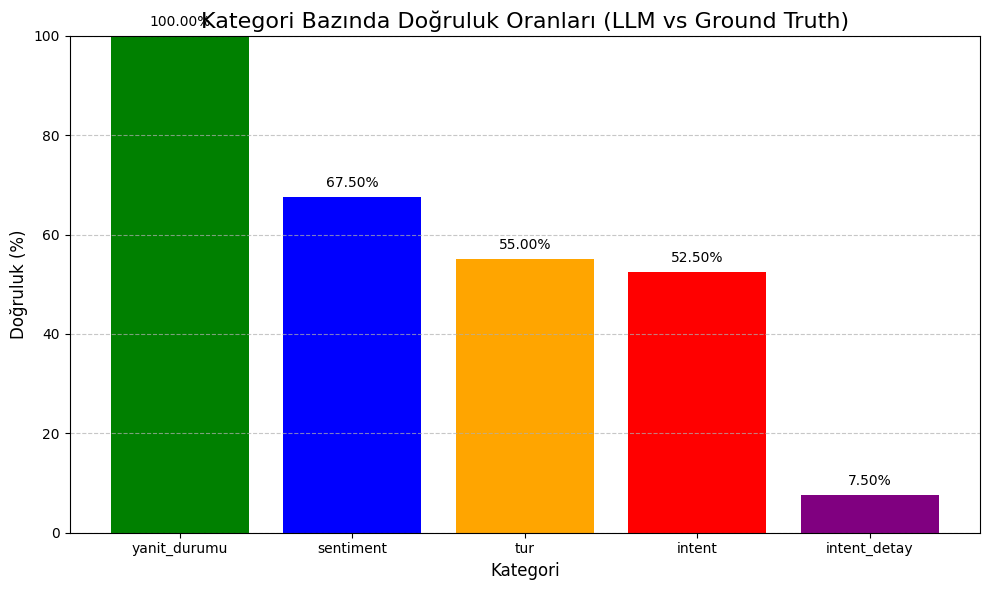

In [7]:
# Sonuçları görselleştirme
plt.figure(figsize=(10, 6))
plt.bar(categories, accuracies, color=['green', 'blue', 'orange', 'red', 'purple'])
plt.title('Kategori Bazında Doğruluk Oranları (LLM vs Ground Truth)', fontsize=16)
plt.ylabel('Doğruluk (%)', fontsize=12)
plt.xlabel('Kategori', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(accuracies):
    plt.text(i, v + 2, f'{v:.2f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('outputs/accuracy_comparison.png')
plt.show()

Veriler başarıyla yüklendi.


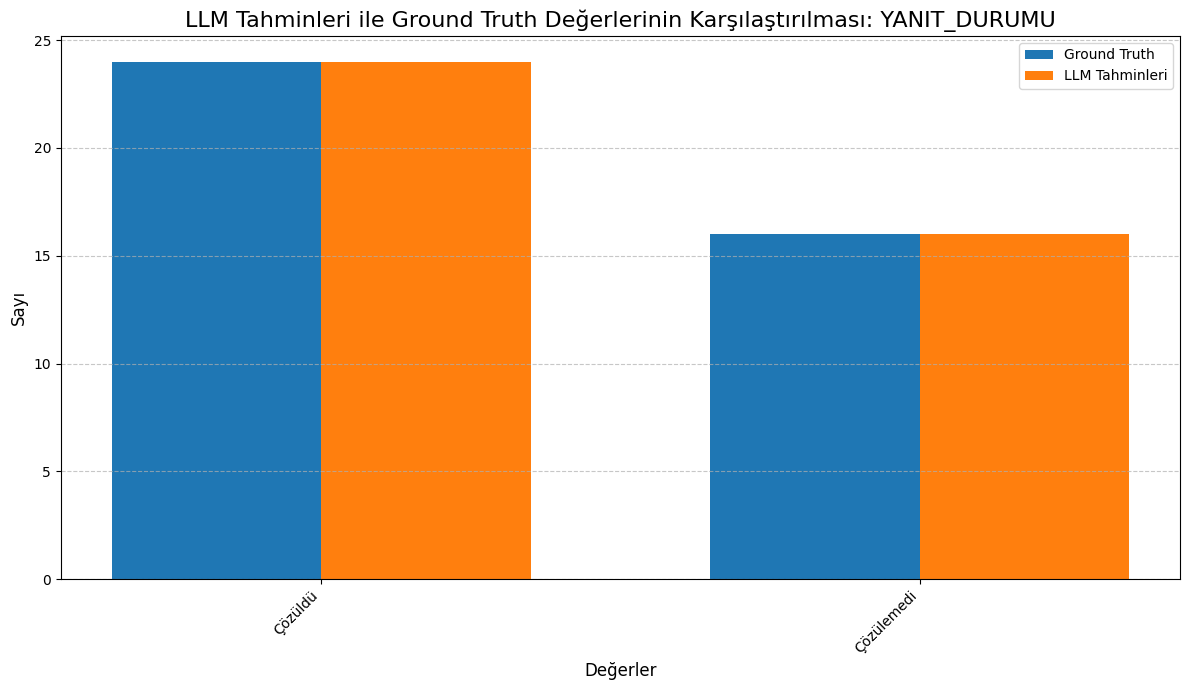

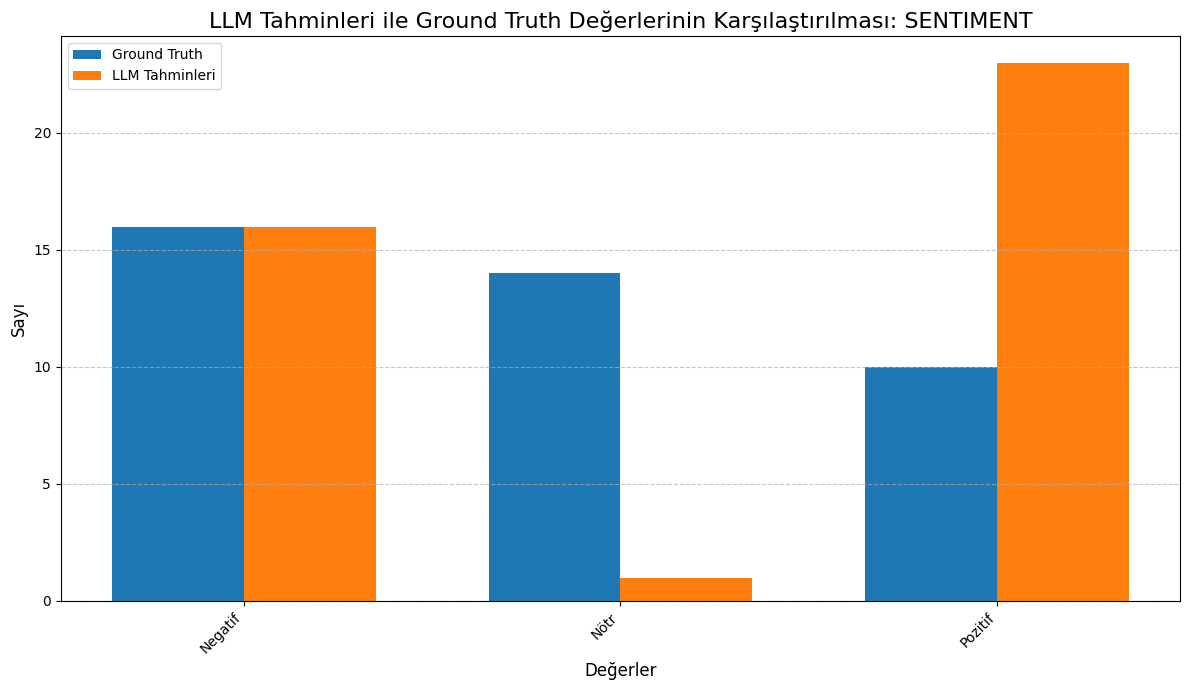

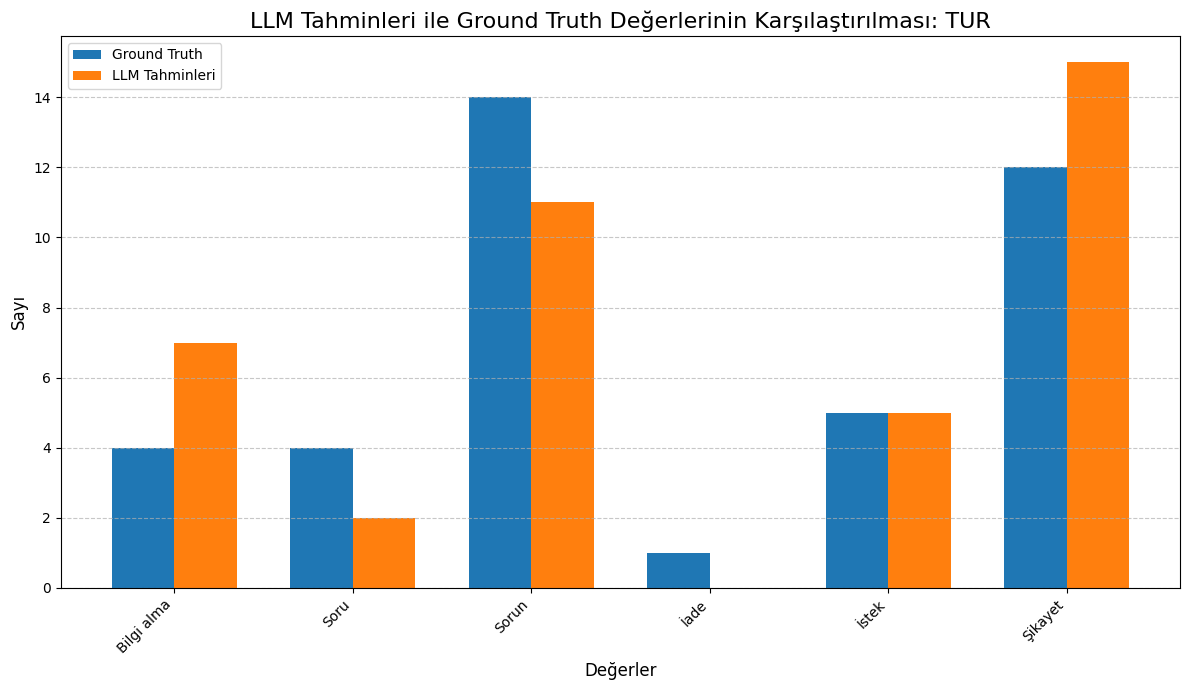

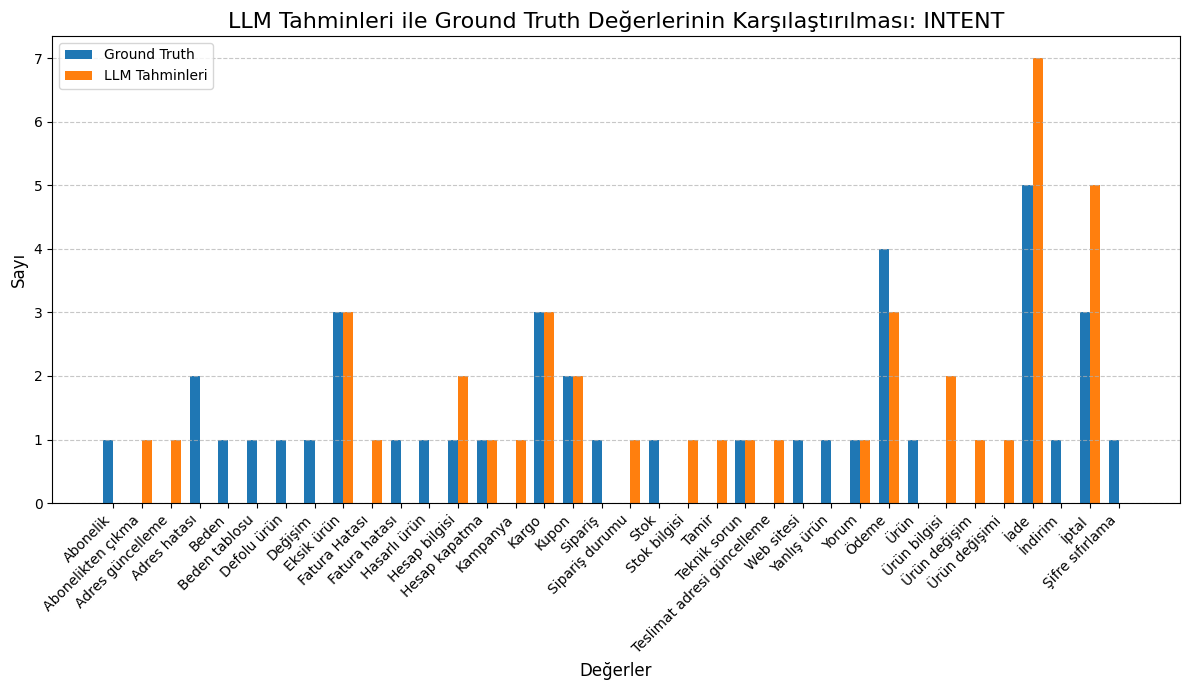

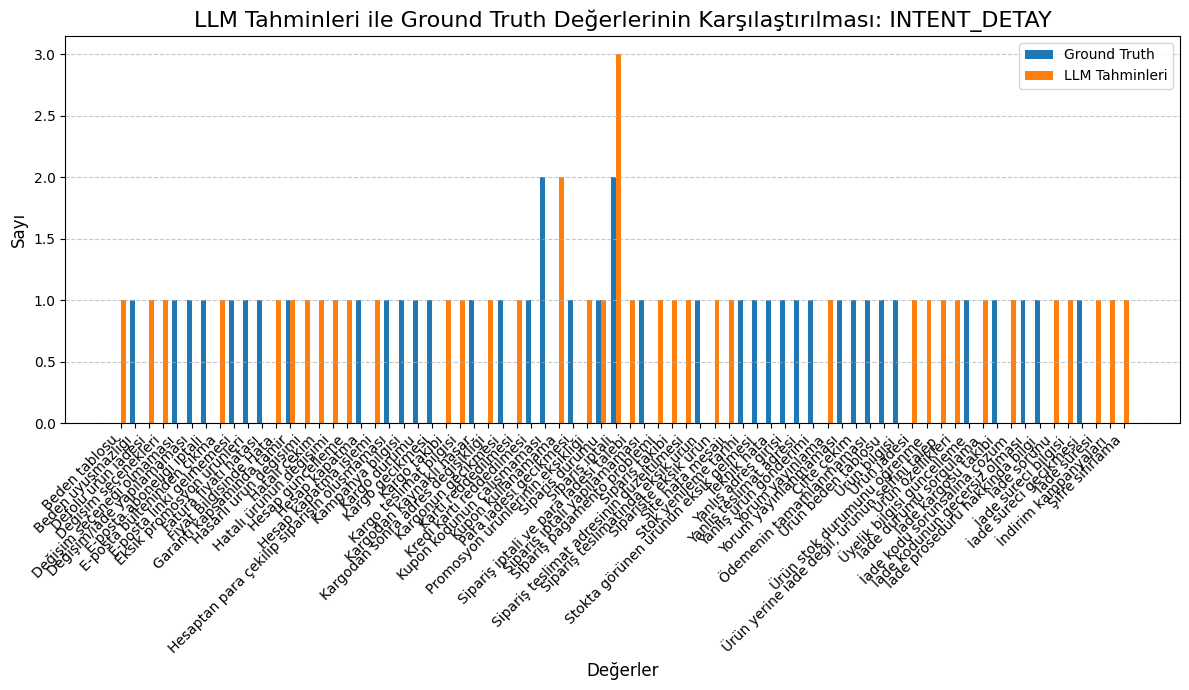

In [9]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import os
import numpy as np

# Veri setlerini yükle
try:
    df_truth = pd.read_excel(os.path.join('..', 'outputs', 'trendyol_mila.xlsx'), sheet_name='sohbetler')
    df_preds = pd.read_csv(os.path.join('..', 'outputs', 'preds_mila_turfix.csv'))
    print('Veriler başarıyla yüklendi.')
except FileNotFoundError as e:
    print(f"Hata: {e}. Lütfen dosyaların 'outputs' klasöründe olduğundan emin olun.")
    # Jupyter Notebook'ta hata vermemek için durdur
    raise

# Kolon isimlerini birleştirme için eşitleme
df_preds = df_preds.rename(columns={'conversation_id': 'sohbet_id'})

# Tahmin JSON'larını ayrıştırma ve yeni sütunlar oluşturma
def parse_prediction(pred_json):
    try:
        data = json.loads(pred_json)
        return pd.Series({
            'pred_yanit_durumu': data.get('yanit_durumu'),
            'pred_sentiment': data.get('sentiment'),
            'pred_tur': data.get('tur'),
            'pred_intent': data.get('intent'),
            'pred_intent_detay': data.get('intent_detay')
        })
    except json.JSONDecodeError:
        return pd.Series({
            'pred_yanit_durumu': None,
            'pred_sentiment': None,
            'pred_tur': None,
            'pred_intent': None,
            'pred_intent_detay': None
        })

# 'prediction' sütunu varsa JSON'u ayrıştır
if 'prediction' in df_preds.columns:
    parsed_preds = df_preds['prediction'].apply(parse_prediction)
    df_preds = pd.concat([df_preds, parsed_preds], axis=1)

# Birleştirme öncesi gereksiz kolonları temizle
# df_preds dosyasında 'pred_' ile başlayan kolonlar zaten varsa bu adım atlanabilir.
# Bu kod parçası her iki duruma da uyum sağlamak için tasarlandı.
pred_cols_to_use = [col for col in df_preds.columns if col.startswith('pred_')]
df_merged = pd.merge(df_truth, df_preds[['sohbet_id'] + pred_cols_to_use], on='sohbet_id', how='inner')

# Grafikleme için veri hazırlığı
categories = ['yanit_durumu', 'sentiment', 'tur', 'intent', 'intent_detay']

# Her kategori için karşılaştırmalı çubuk grafiği oluşturma
for category in categories:
    truth_counts = df_merged[category].value_counts().sort_index()
    pred_counts = df_merged[f'pred_{category}'].value_counts().sort_index()

    all_labels = sorted(list(set(truth_counts.index) | set(pred_counts.index)))

    truth_values = [truth_counts.get(label, 0) for label in all_labels]
    pred_values = [pred_counts.get(label, 0) for label in all_labels]

    x = np.arange(len(all_labels))
    width = 0.35

    plt.figure(figsize=(12, 7))
    plt.bar(x - width/2, truth_values, width, label='Ground Truth', color='#1f77b4')
    plt.bar(x + width/2, pred_values, width, label='LLM Tahminleri', color='#ff7f0e')

    plt.ylabel('Sayı', fontsize=12)
    plt.xlabel('Değerler', fontsize=12)
    plt.title(f'LLM Tahminleri ile Ground Truth Değerlerinin Karşılaştırılması: {category.upper()}', fontsize=16)
    plt.xticks(x, all_labels, rotation=45, ha='right')
    plt.legend()

    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()